In [453]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List

BETA = 2 / 3e9


def mesh_discretisation(swidth,
                        slength,
                        sheight,
                        rwidth,
                        rlength,
                        rheight,
                        offset=(0, 0, 0)) -> List[Element]:
    """
    @param offset 
        top left corner (for the first block, it's usually (0,0,0) 
        i.e. origin point)
    Length => Y
    Height => Z
    Width => X
    """
    Ny, Nx, Nz = int(slength / rlength), int(swidth / rwidth), int(sheight /
                                                                   rheight)
    (xoff, yoff, zoff) = offset
    print(f"Nx {Nx} Ny {Ny} Nz {Nz}")
    element_groups: List[Element] = []
    for ix in range(Nx):
        for iy in range(Ny):
            for iz in range(Nz):
                el = Element(xoff + ix * rwidth, yoff + iy * rlength,
                             zoff + iz * rheight, rwidth, rlength, rheight)
                element_groups.append(el)

    return element_groups


class CompositeStructure:
    def __init__(self, composites, power=10):
        calculate the total resistance
        total_resistance = sum(
            [composite.resistance for composite in composites])
        total_current = np.sqrt(power / total_resistance)
        relative_currents = [
            total_current * total_resistance / composite.resistance
            for composite in composites
        ]

        for i, composite in enumerate(composites):
            composite.set_current(relative_currents[i])
        no_els = [len(comp.elements) for comp in composites]
        self.current_density_per_element = self.current_density / no_els

        self.composites = composites
        self.total_area = self.calculate_total_flow_area()

    def calculate_total_flow_area(self):
        total_area = [composite.flow_area for composite in self.composites]
        return sum(total_area)

    def calculate_contribs(self, Xs, Zs, sl):
        total_contribs = np.zeros_like(Xs).astype(np.float32)
        for composite in self.composites:
            total_contribs += composite.calculate_contribs(
                Xs.ravel(), Zs.ravel(), sl).reshape(Xs.shape)

        return total_contribs


class Composite:
    def __init__(self, size, discretisation, offset, resistance=100):
        """
        @param size:
            (W, L, H) aka (x, y, z)
        @param discretisation:
            sizes of tiny element
        """
        self.elements = mesh_discretisation(*size,
                                            *discretisation,
                                            offset=offset)
        self.resistance = resistance
        self.offset = offset
        (self.w, self.l, self.h) = size
        # area in the direction of the current flow
        # for now just y
        self.flow_area = self.w * self.h

    def set_current(self, I, direction='y'):
        element: Element
        for element in self.elements:
            element.set_current(I, direction)

    def get_sides(self):
        all_sides = []
        for el in self.elements:
            yield el.get_sides()

    def calculate_contribs(self, Xs, Zs, sl):
        vals = []
        for xp, zp in zip(Xs, Zs):
            p = (xp, sl, zp)
            points_contributions = 0.0
            el: Element
            for el in self.elements:
                points_contributions += el.get_contribution_at_p(p)
            vals.append(points_contributions)
        return np.array(vals)


class Element:
    def __init__(self, x, y, z, width, length, height):
        self.x0 = x
        self.y0 = y
        self.z0 = z
        self.x1 = x + width
        self.y1 = y + length
        self.z1 = z + height

        self.l = length
        self.w = width
        self.h = height

        # maybe calculate but don't know which side
        self.area = 0.0
        self.AA = self.l * self.w
        self.AB = self.l * self.h
        self.AC = self.w * self.h

        self.I = 0.0
        self._centre = ((self.x1 + self.x0) / 2, (self.y1 + self.y0) / 2,
                        (self.z1 + self.z0) / 2)

    def get_contribution_at_p(self, p) -> float:
        if self.I == 0.0:
            raise ValueError("Current not set")
        if (self.direction == 'y') and (self.y0 <= p[1] < self.y1):
            dist = np.sqrt(sum([(p[i] - self._centre[i])**2 for i in [0, 2]]))
            return 1.0 / dist  # BETA * self.I / dist
        return 0.0

    def set_current(self, I, direction='y'):
        self.I = I
        self.direction = direction

    def set_current_density(self, Iden):
        if self.area == 0.0:
            raise ValueError("Area not set")
        self.I = Iden * (self.area)

    def get_sides(self):
        return [
            # FRONT FACE
            [(self.x0, self.y0, self.z0), (self.x1, self.y0, self.z0),
             (self.x1, self.y1, self.z0), (self.x0, self.y1, self.z0)],

            # BACK FACE
            [(self.x0, self.y0, self.z1), (self.x1, self.y0, self.z1),
             (self.x1, self.y1, self.z1), (self.x0, self.y1, self.z1)],

            # LEFT FACE
            [(self.x0, self.y0, self.z0), (self.x0, self.y0, self.z1),
             (self.x0, self.y1, self.z1), (self.x0, self.y1, self.z0)],

            # RIGHT FACE
            [(self.x1, self.y0, self.z0), (self.x1, self.y0, self.z1),
             (self.x1, self.y1, self.z1), (self.x1, self.y1, self.z0)],

            # TOP FACE
            [(self.x0, self.y1, self.z0), (self.x1, self.y1, self.z0),
             (self.x1, self.y1, self.z1), (self.x0, self.y1, self.z1)],

            # BOTTOM FACE
            [(self.x0, self.y0, self.z0), (self.x1, self.y0, self.z0),
             (self.x1, self.y0, self.z1), (self.x0, self.y0, self.z1)],
        ]

(0, 0, 0)
Nx 6 Ny 20 Nz 5
(0, 0, 20)
Nx 6 Ny 20 Nz 5
(0, 0, 40)
Nx 6 Ny 20 Nz 5
# Elements: 600


Text(0.5, 0, 'Z [HEIGHT]')

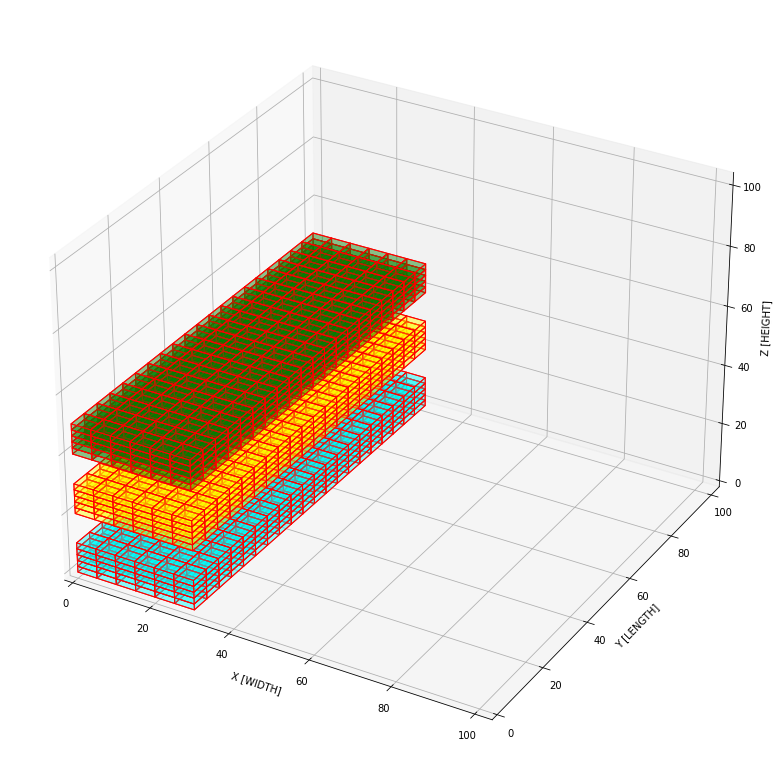

In [454]:
%matplotlib inline
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection, Line3DCollection

sizeW = 30
sizeL = 100
sizeH = 10

max_grid = max(sizeW, sizeL, sizeH)
composites = []
for i in range(3):
    offset = (0, 0, 2*sizeH * i)
    print(offset)
    composite = Composite(size=(sizeW, sizeL, sizeH),
                          discretisation=(5, 5, 2),
                          offset=offset)
    composites.append(composite)

fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111, projection='3d')
print(f"# Elements: {len(elements)}")

colors = ('cyan', 'yellow', 'green')
for color, composite in zip(colors, composites):
    for sides in composite.get_sides():
        ax.add_collection3d(
            Poly3DCollection(sides,
                             facecolors=color,
                             linewidths=1,
                             edgecolors='r',
                             alpha=.25))


ax.set_xlim([0, max_grid + 2])
ax.set_ylim([0, max_grid + 2])
ax.set_zlim([0, max_grid + 2])

ax.set_xlabel("X [WIDTH]")
ax.set_ylabel("Y [LENGTH]")
ax.set_zlabel("Z [HEIGHT]")

Nx 6 Ny 20 Nz 5
Nx 6 Ny 20 Nz 5
Nx 6 Ny 20 Nz 5


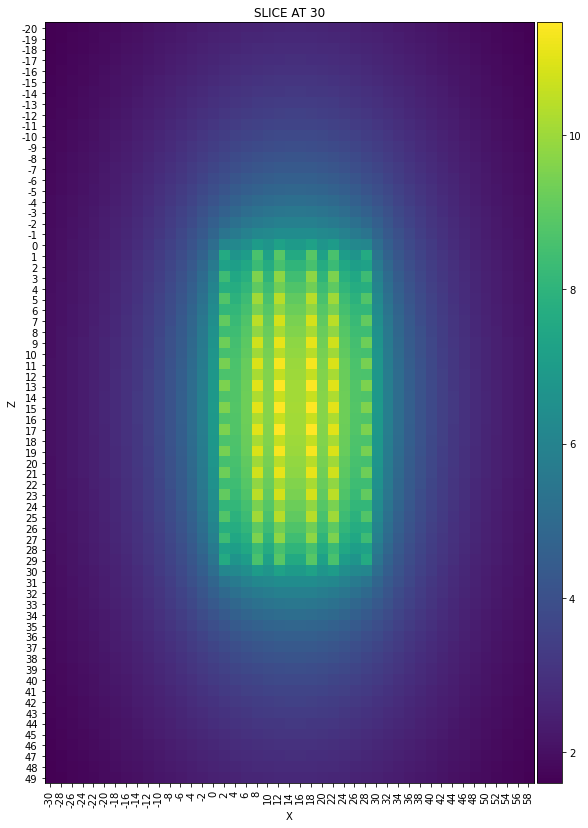

In [486]:
# x, y, z

sizeW = 30
sizeL = 100
sizeH = 10

max_grid = max(sizeW, sizeL, sizeH)

N = 3
z = np.arange(-sizeH*2, sizeH * (N + 2), 1)
x = np.arange(-sizeW, sizeW * 2, 2)
X, Z = np.meshgrid(x, z)
sl = 30
org_s = X.shape

composites = []
CC = np.zeros_like(X).astype(float)
for i in range(N):

    composite = Composite(size=(sizeW, sizeL, sizeH),
                          discretisation=(5, 5, 2),
                          offset=(0, 0, i * sizeH))
    composite.set_current(0.1)
    CC += composite.calculate_contribs(X.ravel(), Z.ravel(),
                                      sl).reshape(X.shape)
    composites.append(composite)

# struct = CompositeStructure(composites)

# vals = struct.calculate_contribs(X, Z, sl)
fig, ax = plt.subplots(figsize=(14, 14))

im = ax.imshow(CC)
ax.set_xlabel("X")
ax.set_ylabel("Z")
ax.set_xticks(np.arange(len(x)))
ax.tick_params(axis='x', rotation=90)
ax.set_yticks(np.arange(len(z)))
ax.set_xticklabels(x)
ax.set_yticklabels(z)
ax.set_title(f"SLICE AT {sl}")

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

cb = fig.colorbar(im, cax=cax, orientation='vertical')

<IPython.core.display.Javascript object>


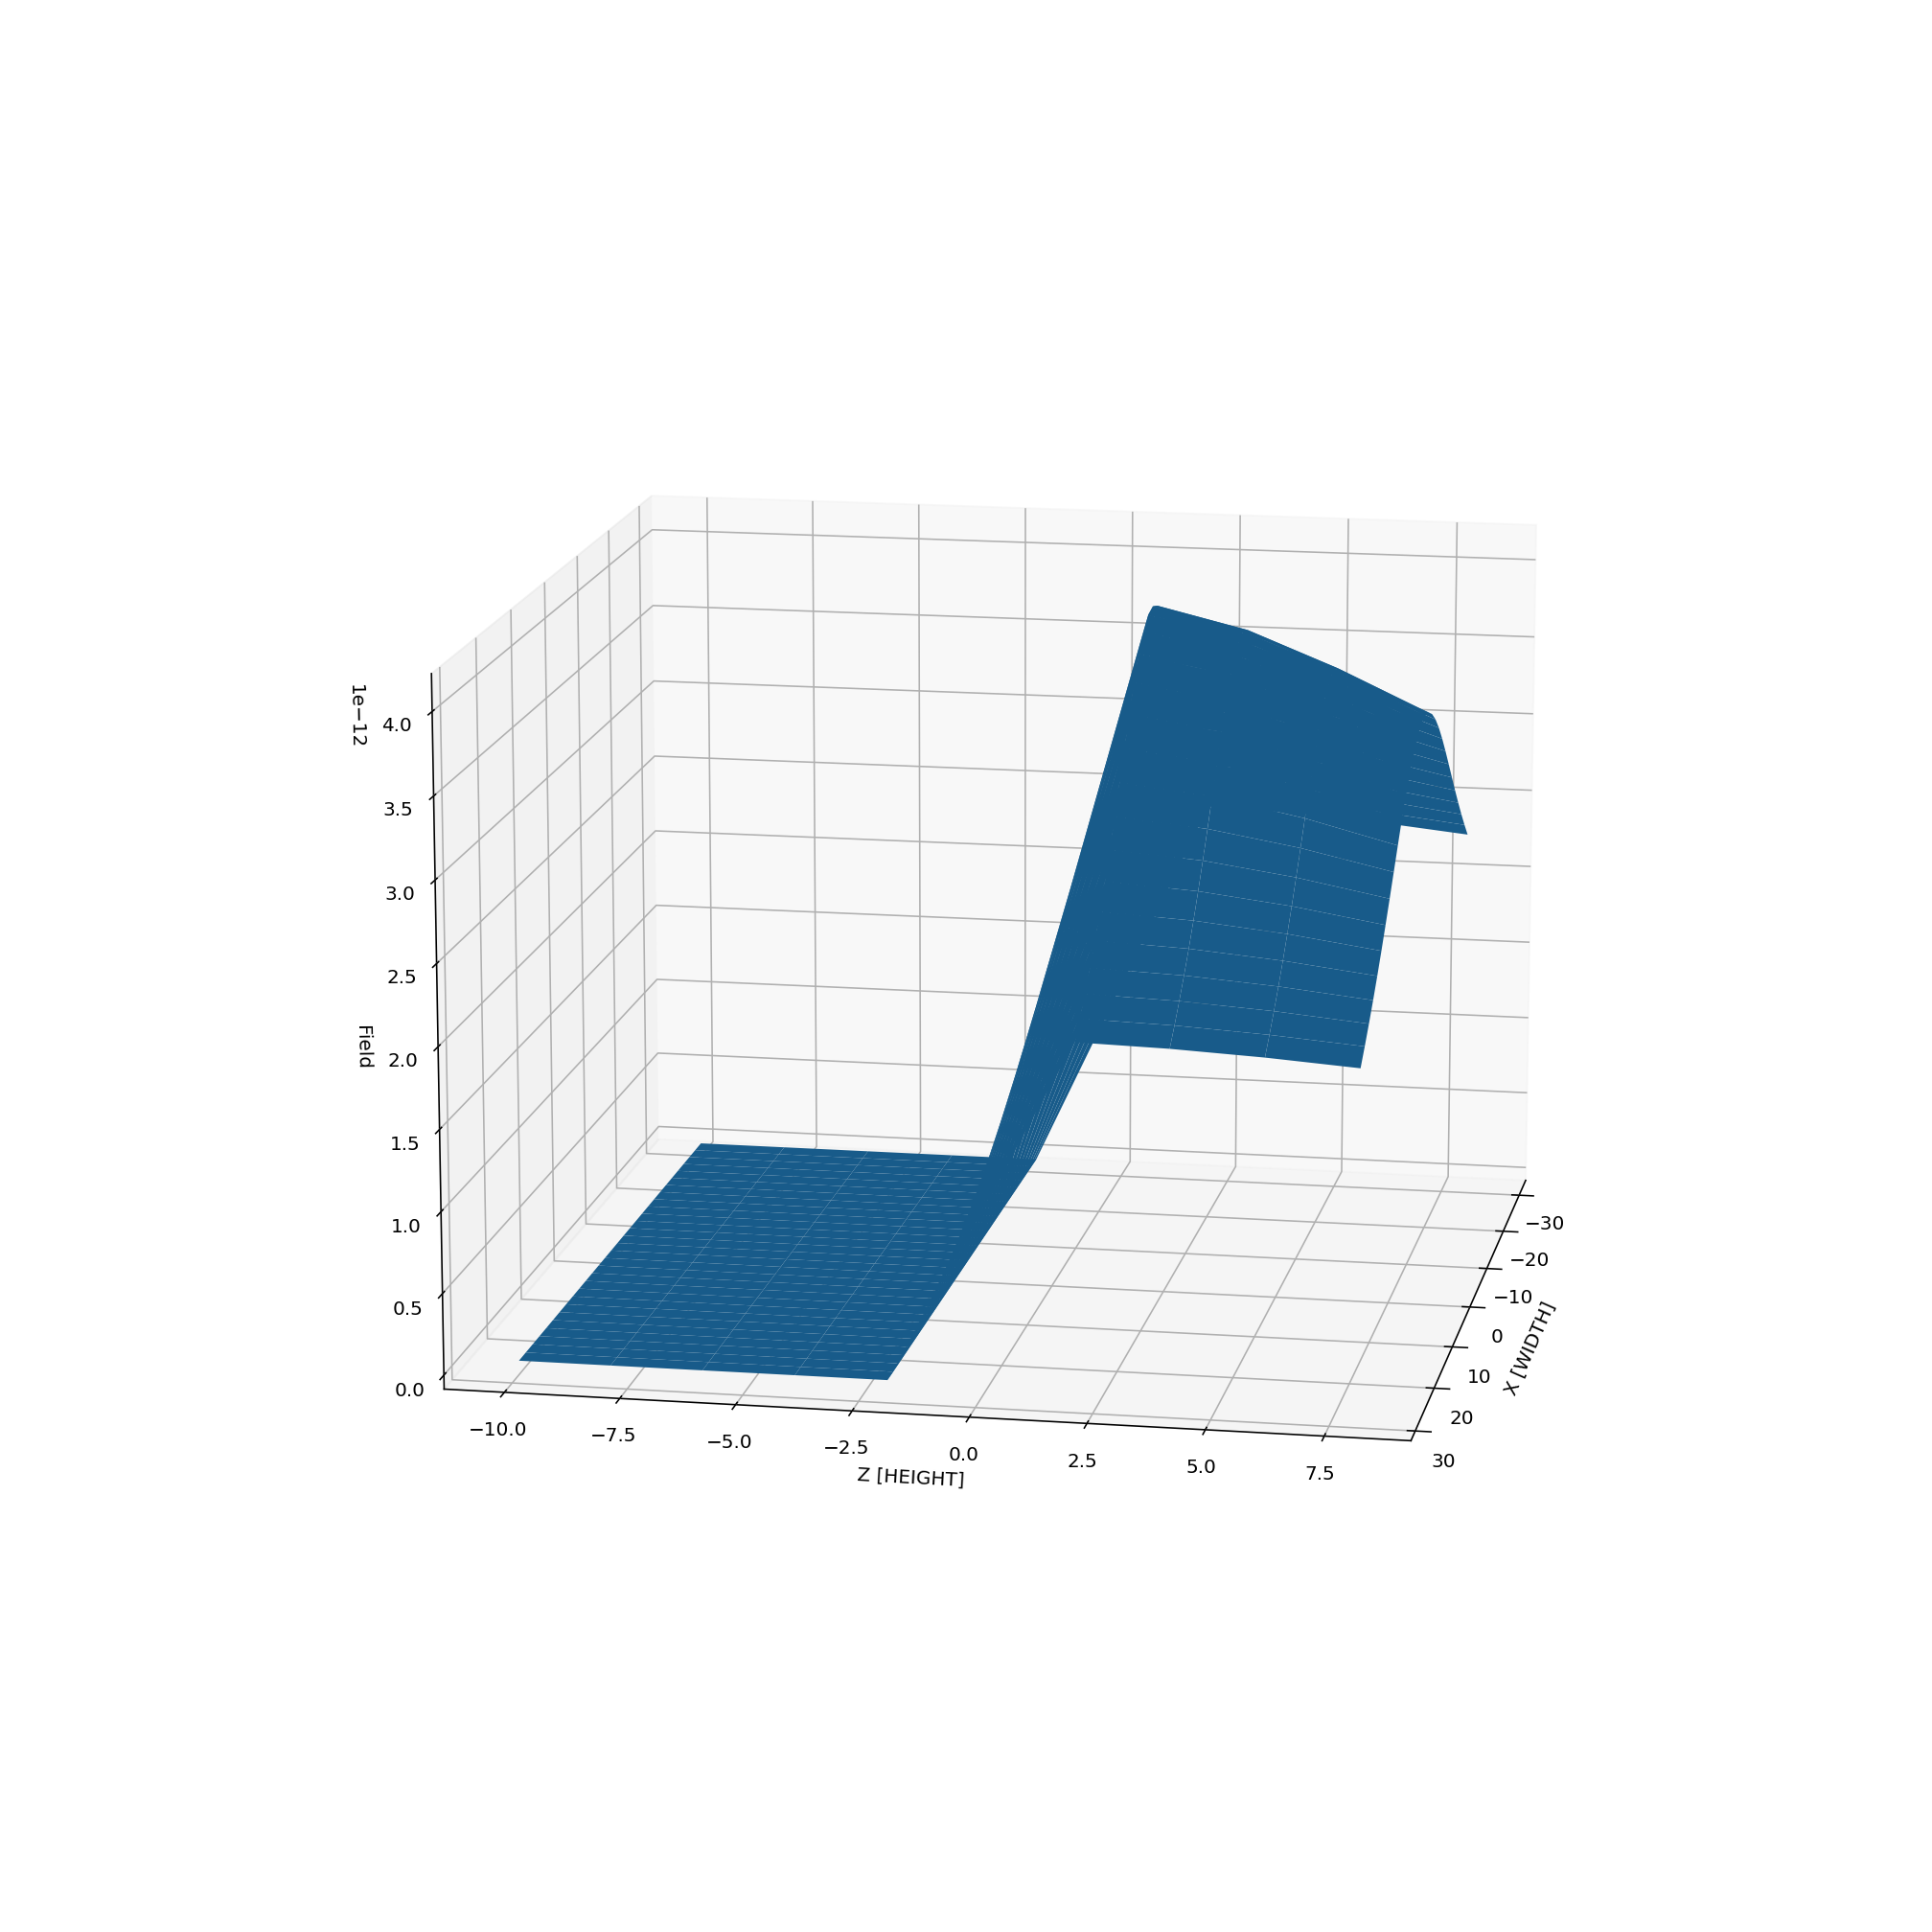

Text(0.5, 0, 'Field')

In [173]:
%matplotlib notebook
fig = plt.figure(figsize=(14, 14))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Z, vals)
ax.set_xlabel("X [WIDTH]")
ax.set_ylabel("Z [HEIGHT]")
ax.set_zlabel("Field")

Nx 6 Ny 20 Nz 5


<IPython.core.display.Javascript object>


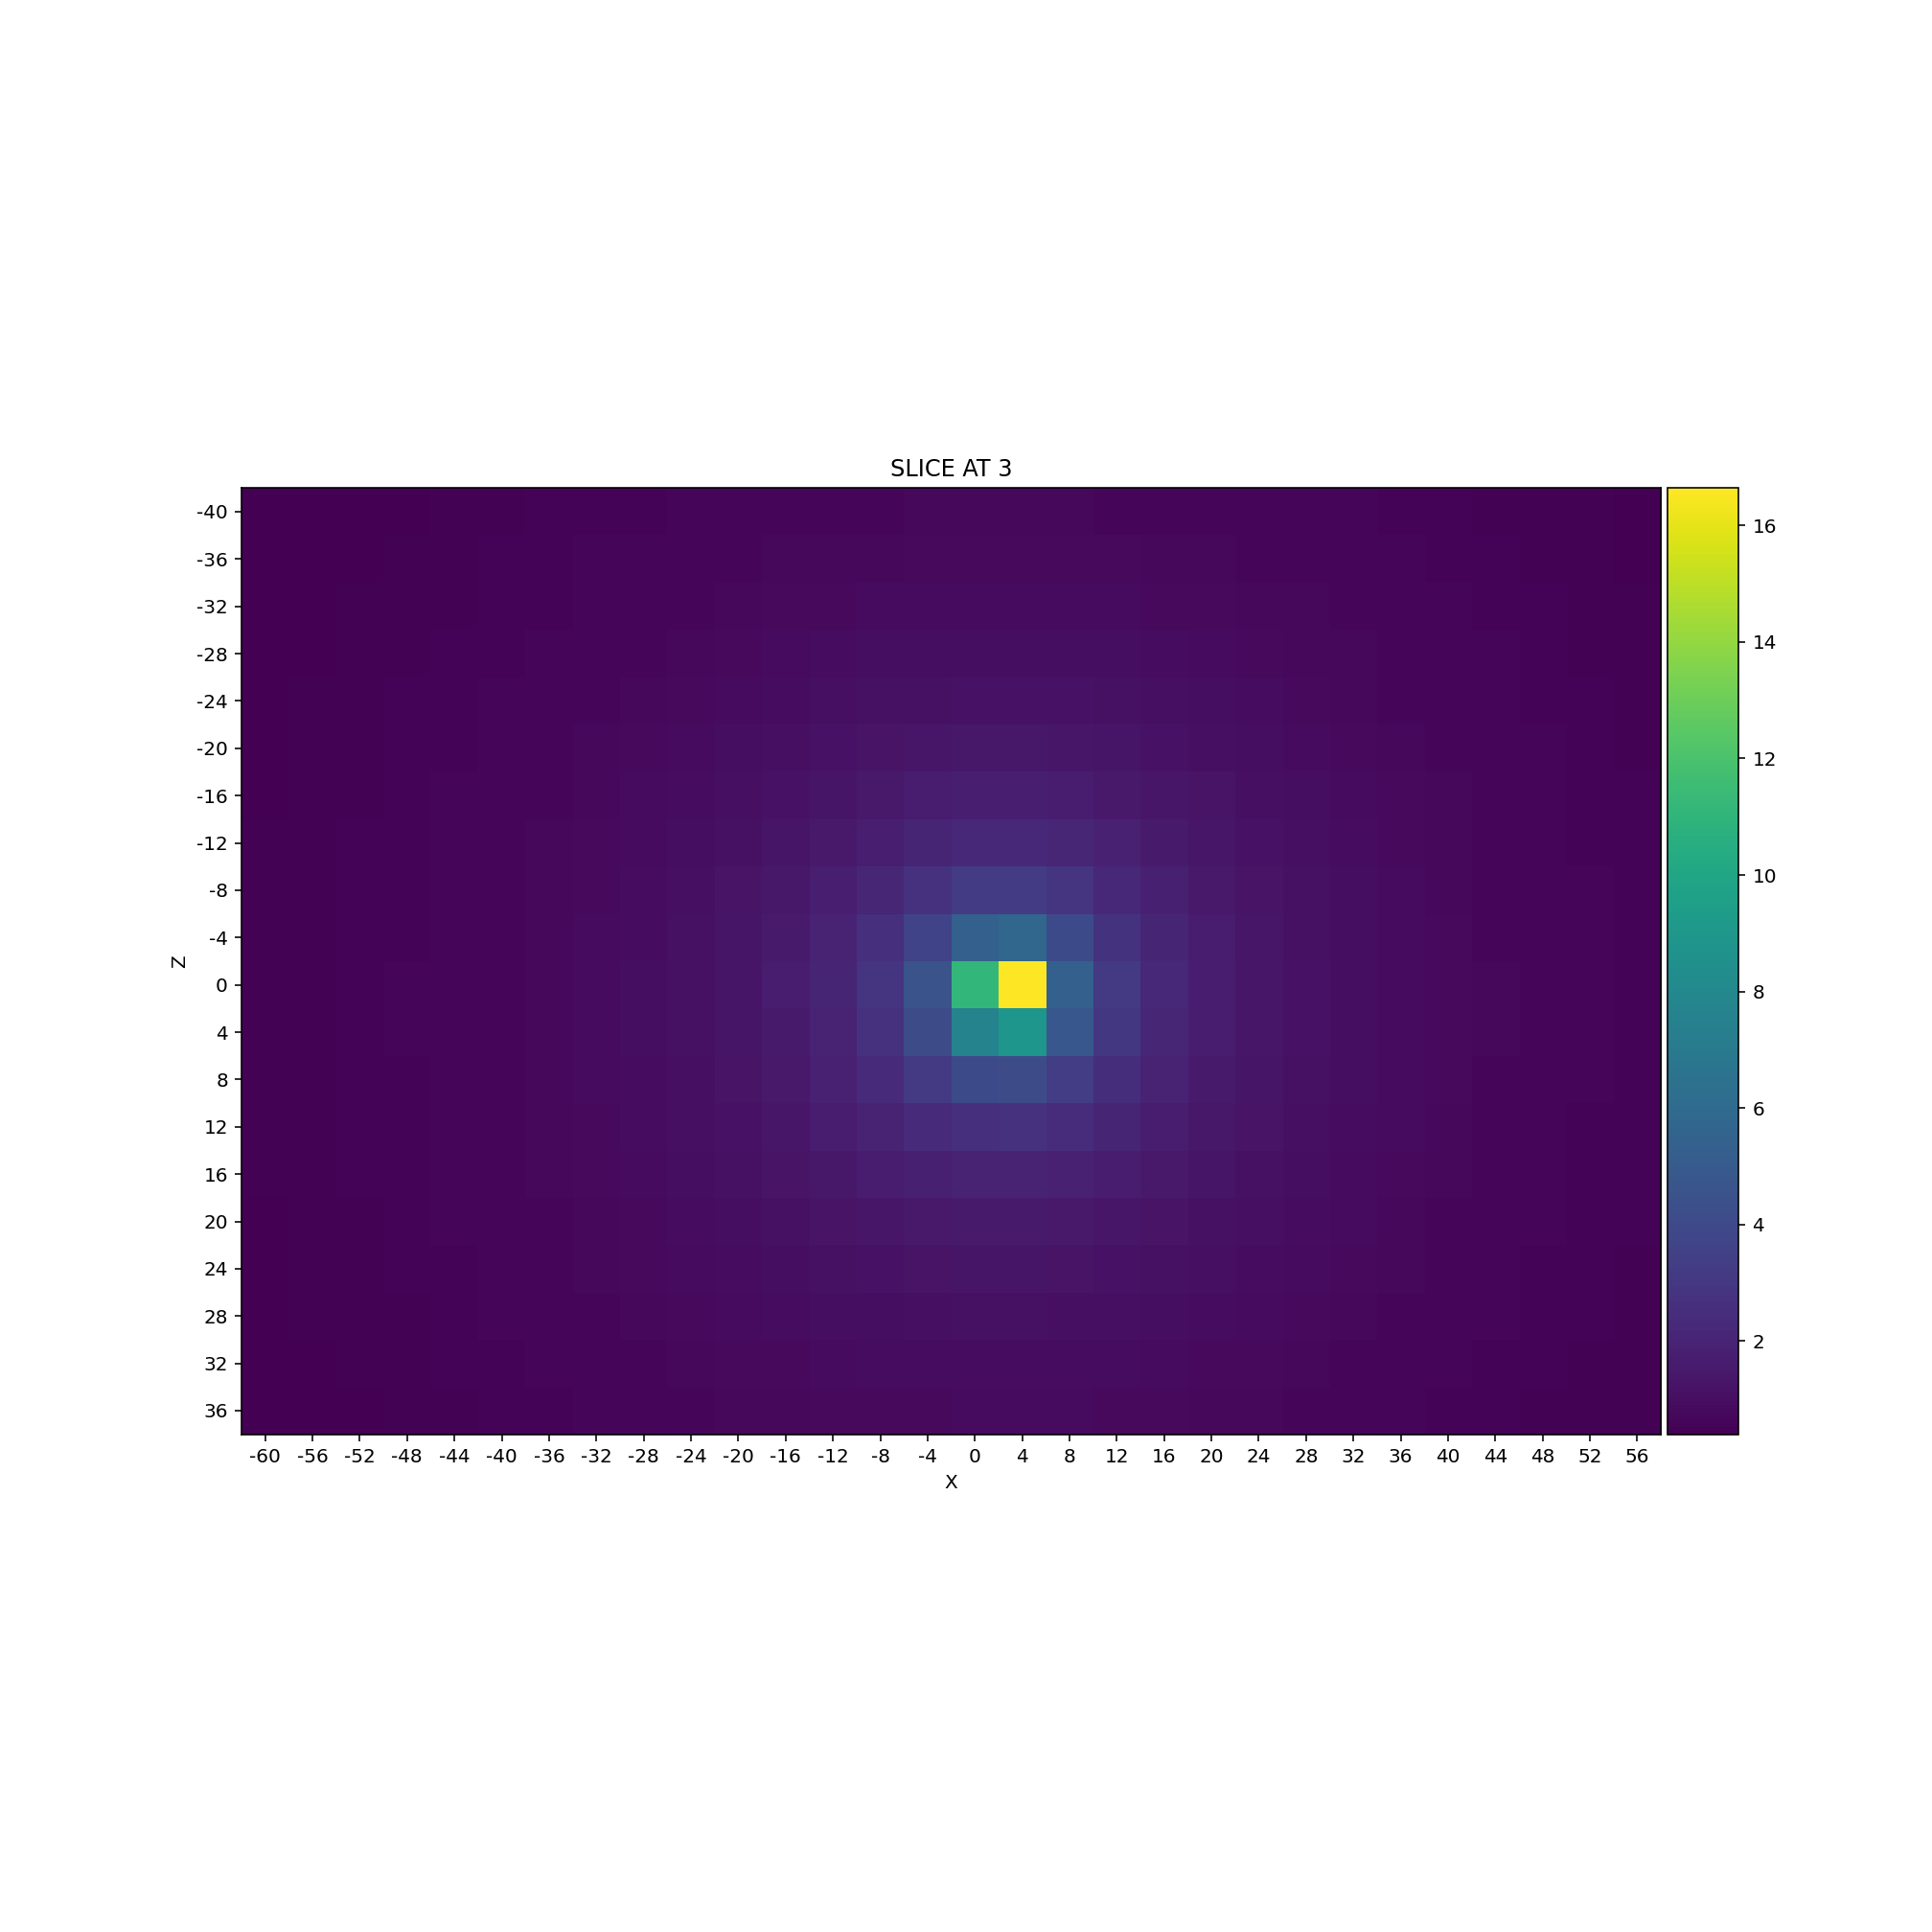

In [355]:
from mpl_toolkits.axes_grid1 import make_axes_locatable


def calculate_contribs(Xs, Zs, sl):
    vals = []
    for xp, zp in zip(Xs, Zs):
        p = (xp, sl, zp)
        points_contributions = 0.0
        c = 0
        el: Element
        for el in elements:
#             if not (el.y0 <= sl < el.y1):
#                 continue
            points_contributions += el.get_contribution_at_p(p)
        vals.append(points_contributions)
    return np.array(vals)

sizeW = 30 
sizeL = 100
sizeH = 10

max_grid = max(sizeW, sizeL, sizeH)
elements = mesh_discretisation(sizeW, sizeL, sizeH, 5, 5, 2)
current = 1
for el in elements:
    el.set_current(current)


z = np.arange(-sizeH*4, sizeH*4, 4)
x = np.arange(-sizeW*2, sizeW*2, 4)
X, Z = np.meshgrid(x, z)

sl = 3
org_s = X.shape
vals = calculate_contribs(X.ravel(), Z.ravel(), sl).reshape(org_s)


fig, ax = plt.subplots(figsize=(14, 14))

im = ax.imshow(vals)
ax.set_xlabel("X")
ax.set_ylabel("Z")
ax.set_xticks(np.arange(len(x)))
ax.set_yticks(np.arange(len(z)))
ax.set_xticklabels(x)
ax.set_yticklabels(z)
ax.set_title(f"SLICE AT {sl}")

divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

cb = fig.colorbar(im, cax=cax, orientation='vertical')



Nx 10 Ny 10 Nz 2


<IPython.core.display.Javascript object>


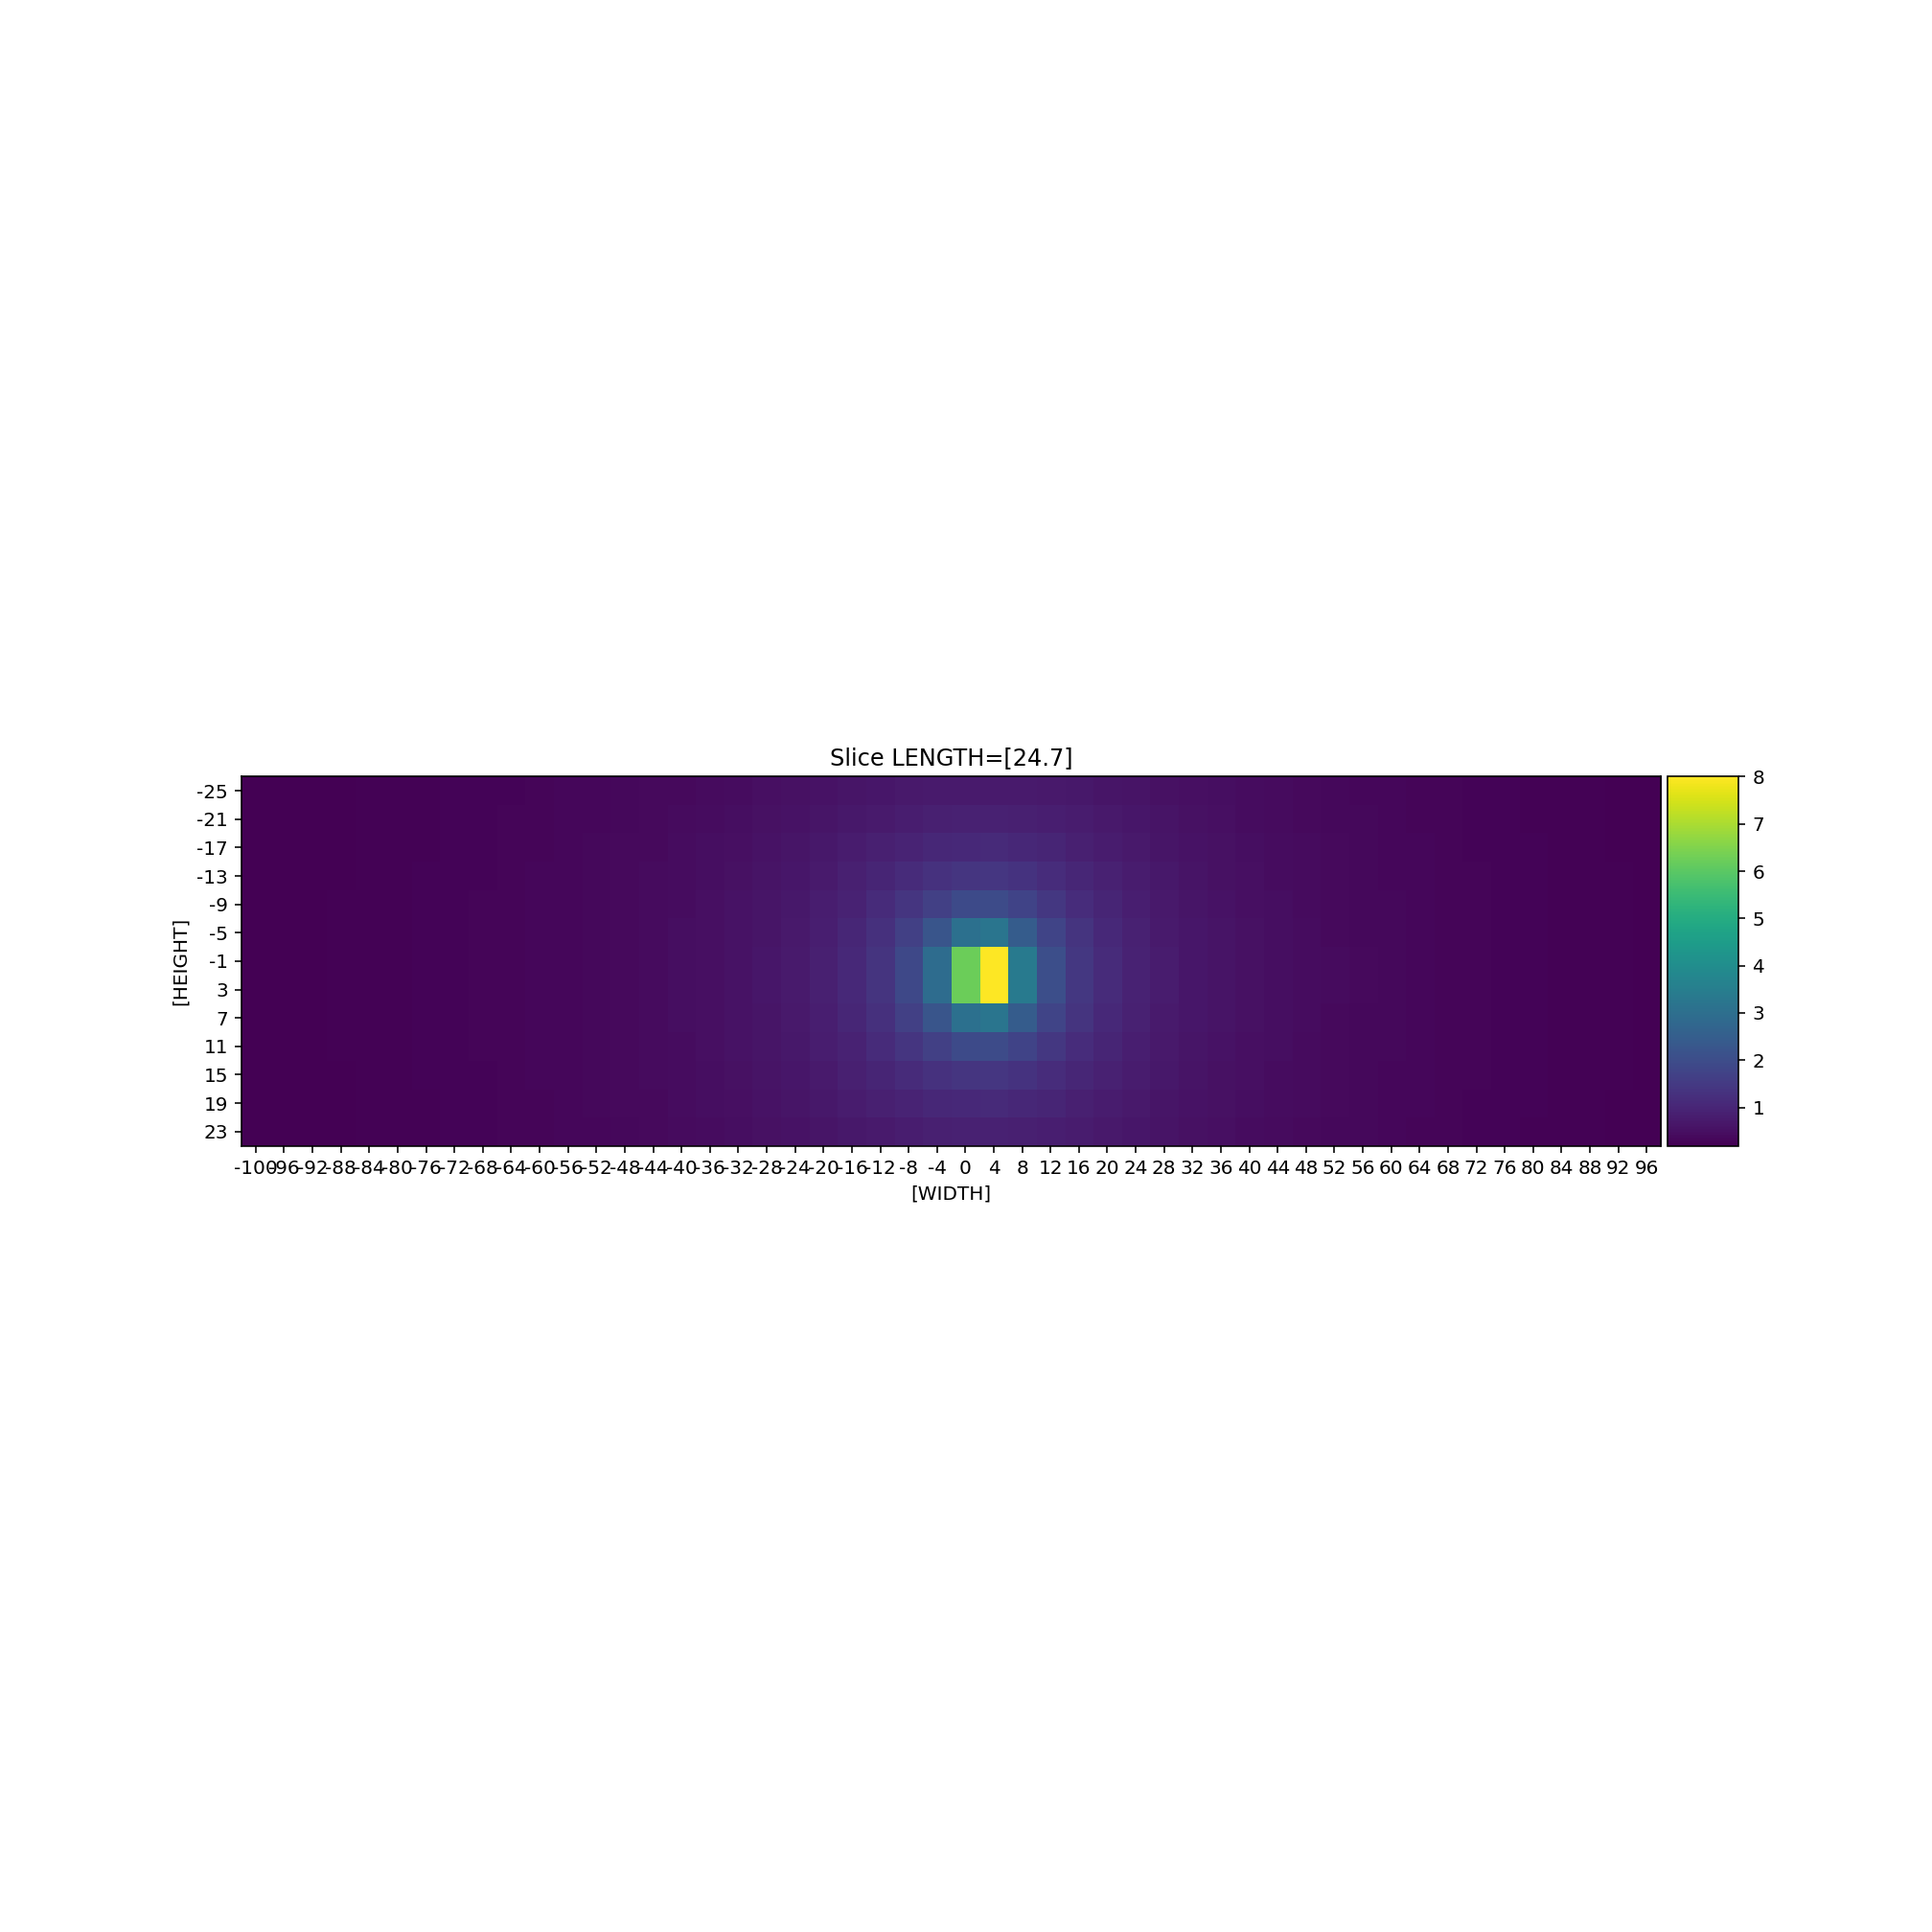

interactive(children=(FloatSlider(value=25.0, description='sl', max=75.0, min=-25.0), Output()), _dom_classes=…

<function __main__.update(sl=25.0)>

In [346]:
%matplotlib notebook
from mpl_toolkits.axes_grid1 import make_axes_locatable
import ipywidgets as ipw

sizeW = 50 
sizeL = 50
sizeH = 5

max_grid = max(sizeW, sizeL, sizeH)
elements = mesh_discretisation(sizeW, sizeL, sizeH, 5, 5, 2)
current = 1e-3
for el in elements:
    el.set_current(current)

z = np.arange(-sizeH*5, sizeH*5, 4)
x = np.arange(-sizeW*2, sizeW*2, 4)
X, Z = np.meshgrid(x, z)
org_s = X.shape

current = 1e-3
for el in elements:
    el.set_current(current)


vals = calculate_contribs(X.ravel(), Z.ravel(), sizeL/2).reshape(org_s)
    
fig, ax = plt.subplots(figsize=(14, 14))
ax.set_xlabel("[WIDTH]")
ax.set_ylabel("[HEIGHT]")
ax.set_xticks(np.arange(len(x)))
ax.set_yticks(np.arange(len(z)))
ax.set_xticklabels(x)
ax.set_yticklabels(z)


im = ax.imshow(vals)
divider = make_axes_locatable(ax)
cax = divider.append_axes('right', size='5%', pad=0.05)

cb = fig.colorbar(im, cax=cax, orientation='vertical')


def update(sl=sizeL/2):
    vals_tmp = calculate_contribs(X.ravel(), Z.ravel(), sl).reshape(org_s)
    im.set_data(vals_tmp)
    ax.set_title(f"Slice LENGTH=[{sl}]")

ipw.interact(update, freq = ipw.FloatSlider(value=0,
                                               min=0,
                                               max=int(sizeL),
                                               step=int(1)))